In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import trompy as tp

from scipy import stats

import dill

rcParams['font.family'] = 'Arial'

savefigs = False

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

In [6]:
with open(DATAFOLDER / "bazzino_data_for_frejus.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]

In [7]:
x_array

,trial,id,condition,infusiontype,cluster_photo,cluster_vel,auc_snips,auc_vel
0,0,PB23,deplete,10NaCl,0,1,0.591521,-1.188873
1,1,PB23,deplete,10NaCl,0,1,1.814684,-2.691587
2,2,PB23,deplete,10NaCl,1,1,0.370967,-4.079002
3,3,PB23,deplete,10NaCl,0,1,0.191150,-3.419706
4,4,PB23,deplete,10NaCl,0,1,0.360981,-0.795429
...,...,...,...,...,...,...,...,...
1955,44,PB75,replete,45NaCl,1,1,0.522845,-1.551007
1956,45,PB75,replete,45NaCl,1,1,-0.550337,1.302696
1957,46,PB75,replete,45NaCl,1,1,-0.406830,2.398969
1958,47,PB75,replete,45NaCl,1,0,-0.539997,2.532370


Cluster 1: n=631, Chi-squared p-value: 0.0000
Cluster 2: n=1329, Chi-squared p-value: 0.0000


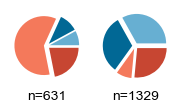

In [8]:
# order for data is rep_10, rep_45, dep_10, dep_45
 
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

f, ax = plt.subplots(ncols=len(x_array.cluster_photo.unique()), figsize=(1.8, 1.2),
                     gridspec_kw={'left': 0.05, 'right': 0.95}
                     )

all_clusters_observed_counts = []

for cluster in np.arange(0,2):
    tmp = x_array.query("cluster_photo == @cluster")# .groupby(["condition", "infusiontype"]).count().cluster
    total = len(tmp)
    
    observed_counts = [
        len(tmp.query("condition == 'replete' & infusiontype == '10NaCl'")),
        len(tmp.query("condition == 'replete' & infusiontype == '45NaCl'")),
        len(tmp.query("condition == 'deplete' & infusiontype == '10NaCl'")),
        len(tmp.query("condition == 'deplete' & infusiontype == '45NaCl'"))
    ]
    all_clusters_observed_counts.append(observed_counts) # Add to list for overall test
    
    pie_props = [count / total if total > 0 else 0 for count in observed_counts]
    
    if total > 0:
        expected_counts = [total / 4, total / 4, total / 4, total / 4]
        
        # Perform Chi-squared goodness-of-fit test
        chi2_stat, p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)
        print(f"Cluster {cluster+1}: n={total}, Chi-squared p-value: {p_value:.4f}")
        
        # You can add an asterisk or other marker to the plot if p_value is significant
        significance_marker = "*" if p_value < 0.05 else ""
    else:
        print(f"Cluster {cluster+1}: n={total}, skipping Chi-squared test (empty cluster)")
        significance_marker = ""
        p_value = 1.0 # or np.nan
    
    ax[cluster].pie(pie_props,
              colors=colors,
              explode=(0.1, 0.1, 0.1, 0.1),
              #autopct='%1.1f%%'
              )
    
    ax[cluster].text(0,-1.7, f"n={total}", ha="center", va="center", fontsize=10, color="k")

if savefigs:
    f.savefig(FIGSFOLDER / "pies_clusters_all.pdf", dpi=600, transparent=True)


In [9]:
# Perform overall Chi-squared test for independence across all clusters
contingency_table = np.array(all_clusters_observed_counts)
np.savetxt(RESULTSFOLDER / "cluster_contingency_table.csv", contingency_table, delimiter=",", fmt='%d') # fmt='%d' for integers


# Check if the contingency table has valid data for the test
if contingency_table.sum() > 0 and not (np.any(contingency_table.sum(axis=1) == 0) or np.any(contingency_table.sum(axis=0) == 0)):
    chi2_overall, p_overall, dof_overall, expected_freq_overall = stats.chi2_contingency(contingency_table)
    print("\nOverall Chi-squared Test for Independence (Clusters vs. Conditions):")
    print(f"Chi2 Statistic: {chi2_overall:.4f}")
    print(f"P-value: {p_overall:.4f}")
    print(f"Degrees of Freedom: {dof_overall}")
    # print("Expected Frequencies Table:\n", expected_freq_overall)
else:
    print("\nOverall Chi-squared Test for Independence could not be performed due to zero sums in rows/columns or empty table.")


Overall Chi-squared Test for Independence (Clusters vs. Conditions):
Chi2 Statistic: 646.1300
P-value: 0.0000
Degrees of Freedom: 3


In [10]:
len(x_array)

1960

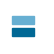

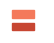

In [11]:
from matplotlib.patches import Rectangle, Patch

f, ax = plt.subplots(figsize=(0.35, 0.45), gridspec_kw={'left': 0.01, 'right': 0.99}
                    )
# for ref: groups = ["10NaCl replete", "45NaCl replete", "10NaCl deplete", "45NaCl deplete"]

groups = ["", ""]

legend_patches = []
for color, text in zip(colors[:2], groups):
    patch = Patch(color=color, label=text)  # Create a patch for the legend
    legend_patches.append(patch)

ax.legend(handles=legend_patches, loc='center', fontsize=8, frameon=False,
          # bbox_to_anchor=(0.5, 0.5),
          # handletextpad=0.5,
          labelspacing=0.2,
          borderpad=0.05)
ax.axis('off')

if savefigs:
    f.savefig(FIGSFOLDER / "legend_pies_replete.pdf", dpi=600, transparent=True)

f, ax = plt.subplots(figsize=(0.35, 0.25), gridspec_kw={'left': 0.01, 'right': 0.99}                     )

legend_patches = []
for color, text in zip(colors[2:], groups):
    patch = Patch(color=color, label=text)  # Create a patch for the legend
    legend_patches.append(patch)

ax.legend(handles=legend_patches, loc='center', fontsize=8, frameon=False,
          # bbox_to_anchor=(0.5, 0.5),
          # handletextpad=0.5,
          labelspacing=0.2,
          borderpad=0.05)
ax.axis('off')

if savefigs:
    f.savefig(FIGSFOLDER / "legend_pies_deplete.pdf", dpi=600, transparent=True)

Cluster 0
(631, 200)
Cluster 1
(1329, 200)


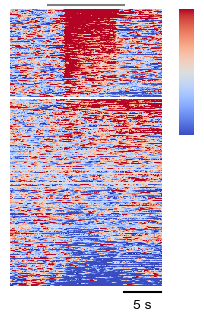

In [12]:
# plot heatmap of all trials sorted first by cluster, then by strength of response using
# sortresponse = np.argsort(np.mean(temp[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]
# or similar

# savefigs=True

list_of_clustered_snips = []
n_of_clusters = []

for cluster in np.arange(0,2):
    print("Cluster", cluster)
    tmp = snips_photo[x_array.cluster_photo == cluster, :]
    sort_order = np.argsort(np.mean(tmp[:,50:150], axis=1))[::-1]
    snips_cluster = tmp[sort_order, :]

    print(snips_cluster.shape)

    snips_cluster.shape
    list_of_clustered_snips.append(snips_cluster)
    n_of_clusters.append(snips_cluster.shape[0])
    
clustered_snips = np.vstack(list_of_clustered_snips)

layout = [["ax", "cbar_ax"],
          ["ax", "empty"]]

f, ax = plt.subplot_mosaic(layout, figsize=(2.3, 3.6), gridspec_kw={'left': 0.1, 'right': 0.9, 'width_ratios': [10, 1], 'wspace': 0.2})  # Adjust width_ratios for colorbar width

cbar_ax = ax["cbar_ax"]
ax["empty"].remove()

ax = ax["ax"]

sns.heatmap(clustered_snips, ax=ax, vmin=-1, vmax=1, cmap="coolwarm", cbar_ax=cbar_ax)
ax.set_yticks([])
ax.set_xticks([])

for c in np.cumsum(n_of_clusters)[:-1]:
    ax.axhline(c, color="white")


ax.plot([150, 198], [2000, 2000], color="k", linewidth=1.5, clip_on=False)
ax.text(174, 2050, "5 s", ha="center", va="top")

ax.plot([50, 150], [-30, -30], color="k", alpha=0.5, linewidth=1.5, clip_on=False)

cbar_ax.set_yticks([])

if savefigs:
    # f.savefig(FIGSFOLDER / "clusters_heatmap_all.pdf", transparent=True)
    f.savefig(FIGSFOLDER / "clusters_heatmap_all.tif",  dpi=300, transparent=True)
    

In [13]:
len(x_array)

1960

In [14]:
df = x_array

def get_prop_of_cluster(df, cluster, condition, infusiontype):
    df_temp = (df
               .query("condition == @condition & infusiontype == @infusiontype")
               )
               
    prop_by_trial = []

    for trial in df_temp.trial.unique():
        n = len(df_temp.query("trial == @trial"))
        n_cluster = len(df_temp.query("trial == @trial & cluster_photo == @cluster"))
        prop_by_trial.append(n_cluster / n)
    
    return prop_by_trial

p = get_prop_of_cluster(df, 0, "replete", "45NaCl")

Cluster 0
Cluster 1


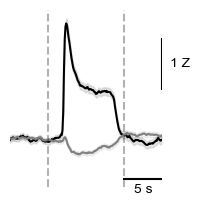

In [15]:
# make line plot with shaded error of cluster 1 and 2

colors = ["#6FA287", "blue"]
colors = ["black", "grey"]


f, [ax, empty] = plt.subplots(ncols=2, figsize=(2.3, 2.3), gridspec_kw={'left': 0.1, 'right': 0.9, 'width_ratios': [10, 1], 'wspace': 0.2})  # Adjust width_ratios for colorbar width

empty.remove()

for cluster, color in zip(np.arange(0,2), colors):
    print("Cluster", cluster)
    snips_cluster = snips_photo[x_array.cluster_photo == cluster, :]
    x = np.arange(snips_cluster.shape[1]) / 10
    mean = np.mean(snips_cluster, axis=0)
    sd = np.std(snips_cluster, axis=0)
    sem = sd / np.sqrt(snips_cluster.shape[0])
    ci = sem * 1.96
    
    ax.plot(x, np.mean(snips_cluster, axis=0), color=color, lw=1.5)
    ax.fill_between(x, mean-ci, mean+ci, alpha=0.1, color=color)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 20)
ax.axvline(5, color="k", linestyle="--", alpha=0.3)
ax.axvline(15, color="k", linestyle="--", alpha=0.3)
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
    

ax.plot([20, 20], [1, 2], color="k")
ax.text(21, 1.5, "1 Z", ha="left", va="center", fontsize=10)

ax.plot([15, 20], [-0.8, -0.8], color="k")
ax.text(17.5, -0.9, "5 s", ha="center", va="top", fontsize=10)

if savefigs:
    f.savefig(FIGSFOLDER / "snips_2clusters_all.pdf", dpi=600, transparent=True)



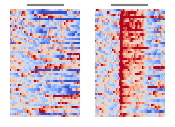

In [12]:
vlim = 2

f, ax = plt.subplots(ncols=2, figsize=(2, 1.4))

id = "PB39"
replete_data = snips_photo[(x_array.id == id) & (x_array.condition == "replete"), :] 
deplete_data = snips_photo[(x_array.id == id) & (x_array.condition == "deplete"), :]

sns.heatmap(data=replete_data, vmin=-vlim, vmax=vlim, ax=ax[0], cmap="coolwarm", cbar=False)
sns.heatmap(data=deplete_data, vmin=-vlim, vmax=vlim, ax=ax[1], cmap="coolwarm", cbar=False)

for axis in ax:
    axis.set_yticks([])
    axis.set_xticks([])
    axis.plot([50,150], [-2, -2], color="k", alpha=0.5, linewidth=1.5, clip_on=False)

if savefigs:
    f.savefig(FIGSFOLDER / "rep_heatmaps_10_all.pdf", transparent=True)




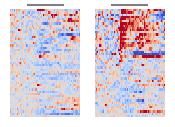

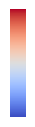

In [13]:
vlim = 2

f, ax = plt.subplots(ncols=2, figsize=(2, 1.4))
f2, cbar_ax = plt.subplots(figsize=(0.2, 1.4))

id = "PB73"
replete_data = snips_photo[(x_array.id == id) & (x_array.condition == "replete"), :] 
deplete_data = snips_photo[(x_array.id == id) & (x_array.condition == "deplete"), :]

sns.heatmap(data=replete_data, vmin=-vlim, vmax=vlim, ax=ax[0], cmap="coolwarm", cbar=True, cbar_ax=cbar_ax)
sns.heatmap(data=deplete_data, vmin=-vlim, vmax=vlim, ax=ax[1], cmap="coolwarm", cbar=False)

for axis in ax:
    axis.set_yticks([])
    axis.set_xticks([])
    axis.plot([50,150], [-2, -2], color="k", alpha=0.5, linewidth=1.5, clip_on=False)

cbar_ax.set_yticks([])

if savefigs:
    f.savefig(FIGSFOLDER / "rep_heatmaps_45_all.pdf", transparent=True)
    f2.savefig(FIGSFOLDER / "rep_heatmaps_45_cbar_all.pdf", transparent=True)

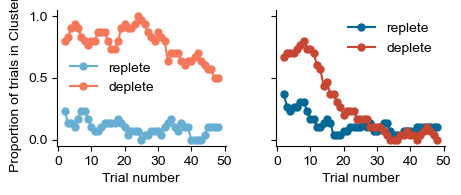

In [14]:
df = x_array

f, ax = plt.subplots(ncols=2, figsize=(5, 2), sharey=True,
                     gridspec_kw={'wspace': 0.3, "bottom": 0.2}
                     )

cluster=0
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

infusiontype = "10NaCl"
for condition, color in zip(["replete", "deplete"], [colors[0], colors[2]]):
        prop_by_trial = get_prop_of_cluster(df, cluster, condition, infusiontype)
        df_to_plot = pd.DataFrame({"prop": prop_by_trial})
        df_to_plot.rolling = df_to_plot.prop.rolling(window=3).mean()
        ax[0].plot(df_to_plot
                   .rolling
                   , label=condition,
                   marker="o",
                   markersize=5,
                   color=color)
        
infusiontype = "45NaCl"
for condition, color in zip(["replete", "deplete"], [colors[1], colors[3]]):
        prop_by_trial = get_prop_of_cluster(df, cluster, condition, infusiontype)
        df_to_plot = pd.DataFrame({"prop": prop_by_trial})
        df_to_plot.rolling = df_to_plot.prop.rolling(window=3).mean()
        ax[1].plot(df_to_plot
                   .rolling
                   , label=condition,
                   marker="o",
                   markersize=5,
                   color=color)


ax[0].set_ylabel("Proportion of trials in Cluster 1")

for axis in ax:
        axis.set_xlabel("Trial number")
        sns.despine(ax=axis)
        axis.set_xticks(np.arange(0, 51, 10),
                        # labels=["0", "8", "16", "24", "32", "40"]
                        )
        axis.set_yticks([0, 0.5, 1])
        axis.legend(frameon=False)
        
if savefigs:
        f.savefig(FIGSFOLDER / "cluster_1_prop_all.pdf", dpi=600, transparent=True)

In [15]:
# Question 1 from Mitch/Alex - probability of transitions between clusters

all_transitions = []
for rat in x_array.id.unique():
    for condition in ["replete", "deplete"]:
        x_array_r = x_array.query("id == @rat & condition == @condition")
        transition_matrix = np.zeros((2,2))
        for i in range(len(x_array_r)-1):
            current_cluster = x_array_r.iloc[i].cluster_photo
            next_cluster = x_array_r.iloc[i+1].cluster_photo
            transition_matrix[current_cluster, next_cluster] += 1
        
        all_transitions.append(transition_matrix)

[[0.74 0.26]
 [0.11 0.89]]


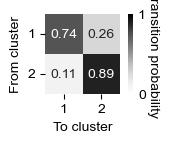

In [16]:
all_transitions = np.array(all_transitions)
all_transitions_mean = np.mean(all_transitions, axis=0)

all_transitions_mean = all_transitions_mean / np.sum(all_transitions_mean, axis=1, keepdims=True)
all_transitions_mean = np.nan_to_num(all_transitions_mean, nan=0.0)
all_transitions_mean = np.clip(all_transitions_mean, 0, 1)
all_transitions_mean = all_transitions_mean.round(2)

print(all_transitions_mean)
f = plt.figure(figsize=(1.6,1.6))
gs = f.add_gridspec(1, 2, width_ratios=[15, 1],
                    left=0.25, bottom=0.3, right=0.8, top=0.8)  # Adjust width_ratios for colorbar width

ax = f.add_subplot(gs[0])
cbar_ax = f.add_subplot(gs[1])

sns.heatmap(all_transitions_mean,
            cmap="Greys",
            vmin=0, vmax=1,
            annot=True,
            ax=ax, cbar_ax=cbar_ax,
            cbar_kws={"orientation": "vertical"},
            # linewidths=0.5, linecolor="black", annot_kws={"size": 8}, fmt=".2f"
)
ax.set_ylabel("From cluster")
ax.set_xlabel("To cluster")

ax.set_yticks(np.arange(2)+0.5, labels=np.arange(1,3), rotation=0)
ax.set_xticks(np.arange(2)+0.5, labels=np.arange(1,3))

cbar_ax.set_yticks([0, 1])
cbar_ax.set_ylabel("Transition probability", rotation=-90, labelpad=10, fontsize=10)
cbar_ax.tick_params(axis='both', which='both', length=0)

if savefigs:
        f.savefig(FIGSFOLDER / "cluster_transitions_all.pdf", dpi=600, transparent=True)

In [17]:
all_transitions_sum = np.sum(all_transitions, axis=0)

In [18]:
all_transitions_sum


array([[ 461.,  161.],
       [ 145., 1153.]])

In [19]:
all_transitions_sum[0,1]

np.float64(161.0)

In [20]:
from statsmodels.stats.proportion import proportion_confint
all_transitions_sum = np.sum(all_transitions, axis=0)

# Example: Observed transitions
n_A_to_B = all_transitions_sum[0,1]
n_A_total = np.sum(all_transitions_sum, axis=1)[0]
n_B_to_A = all_transitions_sum[1,0]
n_B_total = np.sum(all_transitions_sum, axis=1)[1]

# Added: Observed transitions for staying in the same state
n_A_to_A = all_transitions_sum[0,0]
n_B_to_B = all_transitions_sum[1,1]

# Confidence intervals
ci_A_to_B = proportion_confint(n_A_to_B, n_A_total, alpha=0.05, method='normal')
ci_B_to_A = proportion_confint(n_B_to_A, n_B_total, alpha=0.05, method='normal')

# Added: Confidence intervals for staying in the same state
ci_A_to_A = proportion_confint(n_A_to_A, n_A_total, alpha=0.05, method='normal')
ci_B_to_B = proportion_confint(n_B_to_B, n_B_total, alpha=0.05, method='normal')

print(f"95% CI for P(A -> A): {ci_A_to_A}, {np.sum(ci_A_to_A) / 2:.4f} +/- {np.diff(ci_A_to_A)[0] / 2:.4f}")
print(f"95% CI for P(A -> B): {ci_A_to_B}, {np.sum(ci_A_to_B) / 2:.4f} +/- {np.diff(ci_A_to_B)[0] / 2:.4f}")
print(f"95% CI for P(B -> A): {ci_B_to_A}, {np.sum(ci_B_to_A) / 2:.4f} +/- {np.diff(ci_B_to_A)[0] / 2:.4f}")
print(f"95% CI for P(B -> B): {ci_B_to_B}, {np.sum(ci_B_to_B) / 2:.4f} +/- {np.diff(ci_B_to_B)[0] / 2:.4f}")


95% CI for P(A -> A): (0.7067363635647845, 0.7755787489754085), 0.7412 +/- 0.0344
95% CI for P(A -> B): (0.22442125102459157, 0.2932636364352155), 0.2588 +/- 0.0344
95% CI for P(B -> A): (0.09457332711195894, 0.12884732003750177), 0.1117 +/- 0.0171
95% CI for P(B -> B): (0.8711526799624982, 0.9054266728880411), 0.8883 +/- 0.0171


In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.glm("cluster_photo ~ trial * C(condition) * C(infusiontype)",
                              data=x_array,
                              #groups="id", # Specifies the random effects grouping
                              family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          cluster_photo   No. Observations:                 1960
Model:                            GLM   Df Residuals:                     1952
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -793.78
Date:                Thu, 12 Jun 2025   Deviance:                       1587.6
Time:                        15:16:30   Pearson chi2:                 2.06e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3602
Covariance Type:            nonrobust                                         
                                                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [22]:
df = x_array.query("condition == 'replete'")

model = smf.glm("cluster_photo ~ trial * C(infusiontype)",
                              data=df,
                              #groups="id", # Specifies the random effects grouping
                              family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          cluster_photo   No. Observations:                  980
Model:                            GLM   Df Residuals:                      976
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -340.82
Date:                Thu, 12 Jun 2025   Deviance:                       681.65
Time:                        15:16:30   Pearson chi2:                 1.01e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02727
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [23]:
df = x_array.query("condition == 'deplete'")

model = smf.glm("cluster_photo ~ trial * C(infusiontype)",
                              data=df,
                              #groups="id", # Specifies the random effects grouping
                              family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          cluster_photo   No. Observations:                  980
Model:                            GLM   Df Residuals:                      976
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -452.96
Date:                Thu, 12 Jun 2025   Deviance:                       905.91
Time:                        15:16:30   Pearson chi2:                 1.05e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3681
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### Photo vs behav clusters
Some stuff on comparison of photometry and behaviour clusters but generally behav clustering not working so well

In [42]:
import numpy as np
from scipy.stats import pearsonr


real_corr, pval = pearsonr(x_array.cluster_photo, x_array.cluster_vel)
print("Phi coefficient (Pearson r):", real_corr)
print("p-value:", pval)

# Shuffled distribution
corrs = []
for i in range(1000):
    # Shuffle the cluster_vel array
    shuffled_cluster_vel = np.random.permutation(x_array.cluster_vel)
    # Now you can correlate x_array.cluster_photo with shuffled_cluster_vel
    corr, pval = pearsonr(x_array.cluster_photo, shuffled_cluster_vel)
    corrs.append(corr)

# Convert corrs to a numpy array for easier analysis
corrs = np.array(corrs)

# Calculate the mean and standard deviation of the shuffled correlations
mean_corr = np.mean(corrs)
std_corr = np.std(corrs)
# Print the results
print("Mean of shuffled correlations:", mean_corr)
print("Standard deviation of shuffled correlations:", std_corr)

np.sum(corrs < real_corr) / len(corrs)

Phi coefficient (Pearson r): -0.23335324068152286
p-value: 1.1957586896214596e-25
Mean of shuffled correlations: -0.0009122622884030701
Standard deviation of shuffled correlations: 0.022472763012694925


np.float64(0.0)

In [56]:
df2 = pd.DataFrame(data={"photo": x_array.cluster_photo,
                         "vel": x_array.cluster_vel
})

cluster_corr = np.zeros((2,2))
cluster_corr[0,0] = len(df2.query("photo == 0 & vel == 0"))
cluster_corr[1,0] = len(df2.query("photo == 1 & vel == 0"))
cluster_corr[0,1] = len(df2.query("photo == 0 & vel == 1"))
cluster_corr[1,1] = len(df2.query("photo == 1 & vel == 1"))

In [57]:
cluster_corr

array([[  29.,  602.],
       [ 313., 1016.]])

In [58]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(x_array.cluster_photo, x_array.cluster_vel)
print(cm)

[[  29  602]
 [ 313 1016]]


<Axes: >

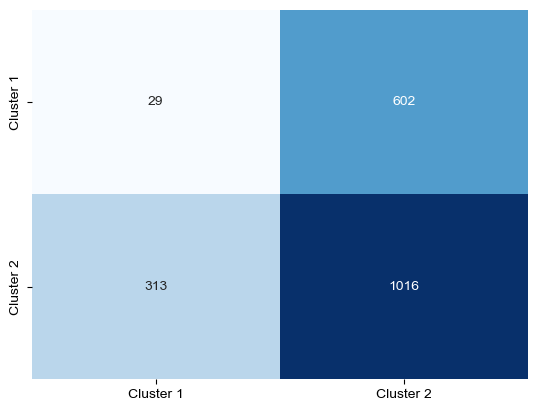

In [59]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
             xticklabels=["Cluster 1", "Cluster 2"],
             yticklabels=["Cluster 1", "Cluster 2"])